In [1]:
## Jupyter notebook in python
## Calculates and plots change in frequency of events

## Caveat: uses every day within the season. Does not remove events within 5 days of each other. therefore it could be showing a change in persistence rather than change in frequency.

In [2]:
import analogue_functions_C3S as my

import xarray as xr
import os
import subprocess
import numpy as np
import iris
import calendar
import matplotlib.pyplot as plt
import matplotlib
cmaps = matplotlib.colormaps
import sys
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.feature as cf
import glob
from iris.util import equalise_attributes
from iris.util import unify_time_units
from scipy.stats import genextreme as gev

from scipy.stats.stats import pearsonr
import scipy.stats as stats


/tmp/ipykernel_3609249/2064173385.py:21: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [17]:
# Defining the variables:
date = [2025, 'May', 17]; # Date to assess
R1 = [80, 50, 30, -30] # Analogues domain
ana_var = 'z500' # Circulation variable, 'msl' or 'z500'


In [19]:
### Automated variables - can be adjusted for sensitivity testing

# months to include, automatically three calendar month window around the event
month = date[1]
X = list(calendar.month_abbr)
i=X.index(month)
if 1<i<12:
    months = [X[i-1], X[i], X[i+1]]
elif i == 1:
    months = [X[12], X[i], X[i+1]]
elif i ==12:
    months = [X[i-1], X[i], X[1]]

# Or use this line to manually select different month set (can be full year)
#months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months = ['Mar','Apr','May']

# start and end of period assessed
Y1 = 1950 # timeslice 1 start year
Y2 = 2025 # timeslice 1 end year

# number of analogues to use - set at 1% (assuming 30 day months) of timeslice 1 days 
N = int(((Y2-Y1)*len(months)*30)/100)
# Or use this line to manually select N
N = 30

In [20]:
event_data = 'era5'
my.ERA5FILESUFFIX = "_daily"
# Initially using ERA5 daily data, if that gives no data switch to extended:
if my.reanalysis_data_single_date('t2m', date)==None:
    my.ERA5FILESUFFIX = "_daily_extended"
    print('ERA5 data not yet available, using ECMWF extended forecast for event data')
    event_data = 'extended'
    
# If extended also not available give error message:
if my.reanalysis_data_single_date('t2m', date)==None:
    print('Data is not available for that date, please select a date between 1 Jan 1950 and the present day')
    quit() ## If the date has not data (ERA5 or extended) then stop here, and print message above

# Find event data
event_msl, event_tp, event_t2m, event_wind = my.event_data_era(event_data, date, ana_var)

P1_msl = my.reanalysis_data(ana_var, Y1, Y2, months)

Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'May', 17]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'May', 17]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2025, 'May', 17]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2025, 'May', 17]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'May', 17]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_sfcWind_daily.nc for date [2025, 'May', 17]


In [21]:
# Find euclidean distance to all events
E = my.extract_region(event_msl, R1)
E = E - E.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
P = my.extract_region(P1_msl, R1)
P = P - P.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
D = []
for Y in np.arange(Y1, Y2):
    D.append(my.euclidean_distance(P.extract(iris.Constraint(year = Y)), E)[:90])


ED_max = np.max(D)
S = 1- D/ED_max # similarity measure, 0 to 1.

/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/pe

In [22]:
# Thresholds - identify value of different percentiles within all data, then count for each year
a, b = np.shape(S)
per5 = np.percentile(S,95) # upper 5%
per10 = np.percentile(S,90) # upper 10%
per20 = np.percentile(S,80) # upper 20%

yr5 = []; yr10 = []; yr20 = []
for each in np.arange(a):
    j = S[each][:]
    yr5.append(sum(i > per5 for i in j))
    yr10.append(sum(i > per10 for i in j))
    yr20.append(sum(i > per20 for i in j))

roll5 = []; roll10 = []; roll20 = []
for i in np.arange(len(yr5)-10):
    roll5.append(np.mean(yr5[i:i+10]))
    roll10.append(np.mean(yr10[i:i+10]))
    roll20.append(np.mean(yr20[i:i+10]))

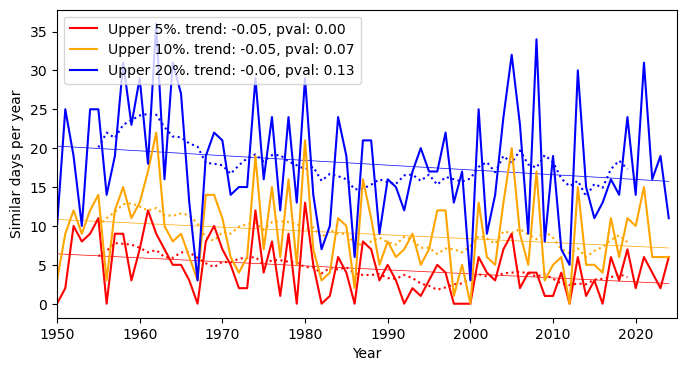

In [23]:
# Plot timeseries with linear trends and 10-yr rolling means
fig, ax = plt.subplots(1,1,figsize = (8, 4))

# linear trends
trend = np.polyfit(np.arange(Y1, Y2), yr10,1)
trendpoly = np.poly1d(trend) 
slope10, intercept, r_value, pval_10, std_err = stats.linregress(np.arange(Y1, Y2), yr10)
ax.plot(np.arange(Y1, Y2), trendpoly(np.arange(Y1, Y2)), color='orange', linewidth=.5)
text10 = 'Upper 10%. trend: '+"%.2f" % round(slope10, 2)+', pval: '+"%.2f" % round(pval_10, 2)

trend = np.polyfit(np.arange(Y1, Y2), yr5,1)
trendpoly = np.poly1d(trend) 
slope5, intercept, r_value, pval_5, std_err = stats.linregress(np.arange(Y1, Y2), yr5)
ax.plot(np.arange(Y1, Y2), trendpoly(np.arange(Y1, Y2)), color='r', linewidth=.5)
text5 = 'Upper 5%. trend: '+"%.2f" % round(slope5, 2)+', pval: '+"%.2f" % round(pval_5, 2)

trend = np.polyfit(np.arange(Y1, Y2), yr20,1)
trendpoly = np.poly1d(trend) 
slope20, intercept, r_value, pval_20, std_err = stats.linregress(np.arange(Y1, Y2), yr20)
ax.plot(np.arange(Y1, Y2), trendpoly(np.arange(Y1, Y2)), color='b', linewidth=.5)
text20 = 'Upper 20%. trend: '+"%.2f" % round(slope20, 2)+', pval: '+"%.2f" % round(pval_20, 2)

ax.plot(np.arange(Y1+5, Y2-5), roll5, 'r:')
ax.plot(np.arange(Y1+5, Y2-5), roll10, color='orange', linestyle=':')
ax.plot(np.arange(Y1+5, Y2-5), roll20, 'b:')

ax.plot(np.arange(Y1, Y2), yr5,'r', label=text5)
ax.plot(np.arange(Y1, Y2), yr10,color='orange', label=text10)
ax.plot(np.arange(Y1, Y2), yr20,'b', label=text20)

ax.set_xlabel('Year')
ax.set_ylabel("Similar days per year")

ax.set_xlim([Y1, Y2])
ax.legend(loc=2)

In [24]:
# Summary print out
print('Summary: Change in frequency of similar circulation days')
print('Event definition:')
print('     Date: ', date)
print('Analogue calulation:')
print('     Months assessed: ', months)
print('     Number of analogues: ', N)
print('     Analogue domain: ', R1)
print('     Circulation variable: ', ana_var)
print('Timeframe:')
print('      Past: ',Y1,'-',Y2)

print('Results:')
text20='Upper 5%. trend: '+"%.2f" % round(slope5, 2)+', pval: '+"%.2f" % round(pval_5, 2)
print(text20)
text20='Upper 10%. trend: '+"%.2f" % round(slope10, 2)+', pval: '+"%.2f" % round(pval_10, 2)
print(text20)
text20='Upper 20%. trend: '+"%.2f" % round(slope20, 2)+', pval: '+"%.2f" % round(pval_20, 2)
print(text20)

print('Conclusions:')
if slope5>0 and slope10>0 and slope20>0:
    print('1. Increasing')
elif slope5<0 and slope10<0 and slope20<0:
    print('1. Decreasing')
else:
    print('1. No trend')

n=0
for i in [pval_5, pval_10, pval_20]:
    if i < 0.05:
        n+=1
if n>1:
    print('2. Significant')
else:
    print('2. Not significant')

Summary: Change in frequency of similar circulation days
Event definition:
     Date:  [2025, 'May', 17]
Analogue calulation:
     Months assessed:  ['Mar', 'Apr', 'May']
     Number of analogues:  30
     Analogue domain:  [80, 50, 30, -30]
     Circulation variable:  z500
Timeframe:
      Past:  1950 - 2025
Results:
Upper 5%. trend: -0.05, pval: 0.00
Upper 10%. trend: -0.05, pval: 0.07
Upper 20%. trend: -0.06, pval: 0.13
Conclusions:
1. Decreasing
2. Not significant
